<a href="https://colab.research.google.com/github/cesar-claros/synergistic/blob/master/socialadsnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch
!pip install gpytorch

In [3]:
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer texlive-latex-base-doc
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  fonts-d

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!cp -r "drive/My Drive/NIPS2020/auxfunc/" .
!cp -r "drive/My Drive/NIPS2020/datasets/" .
!cp -r "drive/My Drive/NIPS2020/style/" .
!cp -r "drive/My Drive/NIPS2020/runs/" .

In [5]:
%load_ext tensorboard

In [6]:
#%%
# Imports
import io #Used as buffer
import sys
import matplotlib
# matplotlib.use('qt5Agg')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import auxfunc.sigfunc as sgn
import seaborn as sns
import torch
from scipy.stats import entropy, spearmanr
from sklearn import model_selection, svm, ensemble, linear_model, pipeline,\
     tree, neighbors, discriminant_analysis, gaussian_process, preprocessing
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern
plt.style.use(['ggplot','style/style.mplstyle'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
#%%
# MODELS
# ====================
# Grid search for parameters and classifiers

models = { 
        'predictor':
            [
            svm.SVC(),
            gaussian_process.GaussianProcessClassifier(),
            linear_model.LinearRegression(),
            linear_model.Lasso(),
            svm.SVR()],
        'name':
            [
            'SVM',
            'GPClassifier',
            'LinReg',
            'Lasso',
            'SVR']}
parameters = [
            {'SVM__kernel':['poly'],'SVM__degree':[3,4,5]},
            {'GPClassifier__kernel':[]},
            {},
            {'Lasso__alpha':np.linspace(0.01,1,10)},
            {'SVR__kernel':['linear'], 'SVR__C':np.logspace(-1, 1, 10), 'SVR__epsilon':np.logspace(-2, 2, 10)} ]


In [9]:
#%%
# Signaling function fitting and evaluation
def signalingFunction(X_train, y_train, y_train_pred_th, X_val, y_val, y_val_pred_th, X_test, y_test, y_test_pred_th, kernel='exponential', norm='l01'):
    # X_train, X_val should be scaled
    # Fit signaling function 
    exp = sgn.signaling(norm=norm) # idx = [train,test,val]
    exp.fit(X_train, y_train, y_train_pred_th, kernel=kernel, n_iter=500, lr=0.01)
    table_val = exp.evaluate(X_val, y_val, y_val_pred_th, rule_grid=np.linspace(0,3,30, endpoint=False))
    table_test = exp.test(X_test, y_test, y_test_pred_th, table_val['rule'].to_numpy(), table_val['eta'].to_numpy())
    table = pd.concat([table_val,table_test],axis=1)
    return table, exp

In [10]:
#%%
# Initialize model
def init_model(input_dim, models, parameters, clf):
    
    if clf=='svm':
      i = 0
    elif clf=='gpc':
      i = 1
      kernel = 1.0 * RBF(length_scale=1.0*np.ones(input_dim)) 
      parameters[i]['GPClassifier__kernel'].append(kernel)
      
    scaler = preprocessing.StandardScaler()
    steps = [('scaler', scaler), (models['name'][i], models['predictor'][i])]
    ppline = pipeline.Pipeline(steps) # define the pipeline object.

    clf = model_selection.GridSearchCV(ppline, param_grid=parameters[i], cv=5, iid=False)
    return clf

In [11]:
#%%
# Soft and thresholded output predictions
def pred_output(model, X):
    if hasattr(model, "decision_function"):
      y_pred_soft = model.best_estimator_.decision_function(X)
      y_pred_th = model.best_estimator_.predict(X)
    else:
      y_pred_soft = model.best_estimator_.predict_proba(X)
      y_pred_th = model.best_estimator_.predict(X)
    return y_pred_soft, y_pred_th

In [12]:
#%%
# Jaccard similarity index
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [13]:
#%%
# Baseline comparison
def baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf):
      if clf=='svm':
          direction = 'closer'
          crit_val = np.abs(y_val_pred_soft.ravel())
          crit_test = np.abs(y_test_pred_soft.ravel())
      else:
          direction = 'further'
          p_val = np.concatenate((y_val_pred_soft,1-y_val_pred_soft),axis=1)
          crit_val = entropy(p_val, axis=1, base=2)
          p_test = np.concatenate((y_test_pred_soft,1-y_test_pred_soft),axis=1)
          crit_test = entropy(p_test, axis=1, base=2)
      
      critFunc = sgn.critEvaluation(norm='l01',direction=direction)
      d_val = critFunc.evaluate(y_val, y_val_pred_th, crit_val)
      d_test = critFunc.test(y_test, y_test_pred_th, crit_test, d_val['thresh'].to_numpy())
      crit_table = pd.concat([d_val,d_test],axis=1)

      gamma = table['rule'].to_numpy().reshape(-1,1)
      f_test = exp.gpr_mean_test + gamma*np.sqrt(exp.gpr_var_test)
      eta = table['eta'].to_numpy().reshape(-1,1)
      theta = crit_table['thresh'].to_numpy().reshape(-1,1)
      if direction == 'closer':
        f_mask, f_idx = np.nonzero(f_test>eta)
      else:
        f_mask, f_idx = np.nonzero(f_test<eta)
      crit_mask, crit_idx = np.nonzero(crit_test.reshape(1,-1)<theta)
      print(list(np.unique(f_mask)))
      print(list(np.unique(crit_mask)))
      assert(list(np.unique(f_mask))==list(np.unique(crit_mask)))
      J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) for i in np.unique(f_mask)]
      crit_table['jaccard']=J
      Sp = [spearmanr(f_test[i,:],crit_test)[0] for i in np.unique(f_mask)]
      crit_table['spearman'] = Sp
      crit_table['gamma'] = gamma
      return crit_table

In [14]:
#%%
# INITIALIZATION
# ==============
# EXPERIMENT SETUP
# ================
# Load data
# -------------
df = pd.read_table('datasets/Social_Network_Ads.csv')
Data_X = df.iloc[:,[2,3]]
Data_y = df.iloc[:,4]
Data_X = Data_X.to_numpy()
Data_y = Data_y.to_numpy()
# For reproducibility
# tf.random.set_seed(54321)
np.random.seed(12345)
torch.manual_seed(0)

In [15]:
#%%
# Assign labels
report_table = []
report_criteria = []
rules = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=123)
addPredictions = False
applyPCA = False
clf = 'svm'
accuracy = 0
for sample, test in kf.split(Data_X):
    X = Data_X[sample]
    y = Data_y[sample]
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.20, random_state=123)
    X_test = Data_X[test]
    y_test = Data_y[test]

    # TRAINING MODEL
    model = init_model(input_dim=X.shape[1], models=models, parameters=parameters, clf=clf)
    model.fit(X_train, y_train)

    y_train_pred_soft, y_train_pred_th = pred_output(model, X_train)
    print('accuracy(Train)={}'.format(np.sum(y_train==y_train_pred_th)/np.size(y_train)))
    y_val_pred_soft, y_val_pred_th = pred_output(model, X_val)
    y_test_pred_soft, y_test_pred_th = pred_output(model, X_test)

    X_train_GP = X_train
    X_val_GP = X_val
    X_test_GP = X_test
    if addPredictions:
            # Add predictions
            X_train_GP = np.concatenate((X_train, y_train_pred_soft), axis=1)
            X_val_GP = np.concatenate((X_val, y_val_pred_soft), axis=1)
            X_test_GP = np.concatenate((X_test, y_test_pred_soft), axis=1)
    scaleX_GP = preprocessing.StandardScaler().fit(np.concatenate((X_train_GP, X_val_GP), axis=0))
    X_train_GP = scaleX_GP.transform(X_train_GP)
    X_val_GP = scaleX_GP.transform(X_val_GP)
    X_test_GP = scaleX_GP.transform(X_test_GP)
    if applyPCA:
            pca_GP = decomposition.PCA(.99).fit(np.concatenate((X_train_GP, X_val_GP), axis=0)) # set percentage of energy preserved by PCA
            # Apply PCA transform to all sets
            X_train_GP = pca_GP.transform(X_train_GP)
            X_val_GP = pca_GP.transform(X_val_GP)
            X_test_GP = pca_GP.transform(X_test_GP)
    
    table, exp = signalingFunction(X_train_GP, y_train, y_train_pred_th, X_val_GP, y_val, y_val_pred_th, X_test_GP, y_test, y_test_pred_th)
    report_table.append(table)
    
    # Baseline for comparison
    crit_table = baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf)
    report_criteria.append(crit_table)

    if accuracy < model.best_estimator_.score(X_val,y_val):
        accuracy = model.best_estimator_.score(X_val,y_val)
        classifier = model.best_estimator_
        X_test_surface_plot = X_test
        y_test_surface_plot = y_test
        X_train_surface_plot = X_train
        y_train_surface_plot = y_train
        X_val_surface_plot = X_val
        y_val_surface_plot = y_val
        scaler_surface_plot = scaleX_GP
        exp_surface_plot = exp
        table_surface_plot = table

    del(model)
# Summary statistics
# f_test = exp.gpr_mean_test + gamma*np.sqrt(exp.gpr_var_test)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


accuracy(Train)=0.8671875
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.206  noise: 0.058
Iter 492/500 - Loss: 0.206  noise: 0.058
Iter 493/500 - Loss: 0.206  noise: 0.058
Iter 494/500 - Loss: 0.206  noise: 0.058
Iter 495/500 - Loss: 0.206  noise: 0.058
Iter 496/500 - Loss: 0.206  noise: 0.058
Iter 497/500 - Loss: 0.206  noise: 0.058
Iter 498/500 - Loss: 0.206  noise: 0.058
Iter 499/500 - Loss: 0.206  noise: 0.058
Iter 500/500 - Loss: 0.206  noise: 0.058
evaluating with cuda...
evaluating with cuda...
[0, 1, 2, 3]
[0, 1, 2, 3]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


accuracy(Train)=0.8359375
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.261  noise: 0.059
Iter 492/500 - Loss: 0.261  noise: 0.059
Iter 493/500 - Loss: 0.261  noise: 0.059
Iter 494/500 - Loss: 0.261  noise: 0.059
Iter 495/500 - Loss: 0.261  noise: 0.059
Iter 496/500 - Loss: 0.261  noise: 0.059
Iter 497/500 - Loss: 0.261  noise: 0.059
Iter 498/500 - Loss: 0.261  noise: 0.059
Iter 499/500 - Loss: 0.261  noise: 0.058
Iter 500/500 - Loss: 0.261  noise: 0.058
evaluating with cuda...
evaluating with cuda...
[0, 1, 2, 3]
[0, 1, 2, 3]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


accuracy(Train)=0.8671875
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.215  noise: 0.060
Iter 492/500 - Loss: 0.215  noise: 0.060
Iter 493/500 - Loss: 0.215  noise: 0.060
Iter 494/500 - Loss: 0.215  noise: 0.060
Iter 495/500 - Loss: 0.215  noise: 0.060
Iter 496/500 - Loss: 0.215  noise: 0.060
Iter 497/500 - Loss: 0.215  noise: 0.060
Iter 498/500 - Loss: 0.214  noise: 0.060
Iter 499/500 - Loss: 0.214  noise: 0.060
Iter 500/500 - Loss: 0.214  noise: 0.060
evaluating with cuda...
evaluating with cuda...
[0, 1, 2, 3]
[0, 1, 2, 3]
accuracy(Train)=0.875


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.152  noise: 0.047
Iter 492/500 - Loss: 0.152  noise: 0.047
Iter 493/500 - Loss: 0.152  noise: 0.046
Iter 494/500 - Loss: 0.152  noise: 0.046
Iter 495/500 - Loss: 0.152  noise: 0.046
Iter 496/500 - Loss: 0.152  noise: 0.046
Iter 497/500 - Loss: 0.152  noise: 0.046
Iter 498/500 - Loss: 0.152  noise: 0.046
Iter 499/500 - Loss: 0.152  noise: 0.046
Iter 500/500 - Loss: 0.152  noise: 0.046
evaluating with cuda...
evaluating with cuda...
[0, 1, 2, 3]
[0, 1, 2, 3]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


accuracy(Train)=0.87109375
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.182  noise: 0.055
Iter 492/500 - Loss: 0.182  noise: 0.055
Iter 493/500 - Loss: 0.182  noise: 0.055
Iter 494/500 - Loss: 0.182  noise: 0.055
Iter 495/500 - Loss: 0.182  noise: 0.055
Iter 496/500 - Loss: 0.182  noise: 0.055
Iter 497/500 - Loss: 0.182  noise: 0.055
Iter 498/500 - Loss: 0.182  noise: 0.055
Iter 499/500 - Loss: 0.181  noise: 0.055
Iter 500/500 - Loss: 0.181  noise: 0.055
evaluating with cuda...
evaluating with cuda...
[0, 1, 2, 3]
[0, 1, 2, 3]


In [ ]:
logs_base_dir = "runs/"
%tensorboard --logdir {logs_base_dir}

In [16]:
##%
# Boxplot (loss reduction in test set)
report_table_concat = pd.concat(report_table)
cols_table = ['p_value','rho_user','%reduction_test']
df_boxplot_table = pd.DataFrame(report_table_concat[cols_table])
df_boxplot_table['label'] = df_boxplot_table.shape[0]*['$f(x)$']
report_criteria_concat = pd.concat(report_criteria)
columns_crit = ['rho_user','%reduction_test']
df_boxplot_crit = pd.DataFrame(report_criteria_concat[columns_crit])
df_boxplot_crit['label'] = df_boxplot_crit.shape[0]*['$g(x)$']
# p-value median
p_value_by_row_index = df_boxplot_table['p_value'].groupby(df_boxplot_table.index)
p_value_median = p_value_by_row_index.median()
# Boxplot (jaccard index in test set)
columns_jac = ['rho_user','jaccard']
df_jaccard = pd.DataFrame(report_criteria_concat[columns_jac])
# Filter experiments with p_value > 0.05
df_boxplot_crit = df_boxplot_crit.loc[df_boxplot_table['p_value'] <= 0.05]
df_jaccard = df_jaccard.loc[df_boxplot_table['p_value'] <= 0.05]
df_boxplot_table = df_boxplot_table.loc[df_boxplot_table['p_value'] <= 0.05]
# Boxplot with filtered values only
frames = [df_boxplot_table, df_boxplot_crit]
df = pd.concat(frames)

In [31]:
# Avoid plotting when median(p_value)>0.5
for i in range(p_value_median.shape[0]):
    if p_value_median.iloc[i]>0.5:
      df.loc[df.index==i,'%reduction_test'] = 0
      df_jaccard[df_jaccard.index==i, 'jaccard'] = 0

In [32]:
# Dataframe for results f(x)
cols = ['rho_user','%reduction_val','budget','%reduction_test']
df_fx = pd.DataFrame(report_table_concat[cols])
results_fx_by_row_index = df_fx.groupby(df_fx.index)
fx_median = results_fx_by_row_index.median()
fx_q1 = results_fx_by_row_index.quantile(q=0.25)
fx_q3 = results_fx_by_row_index.quantile(q=0.75)
# Signaling function statistics (median(q1-q3)) LaTex
output = io.StringIO()
numRows = fx_median.shape[0]
numCols = fx_median.shape[1]
for i in range(numRows):
  row = [r'{}' if p_value_median[i]>0.05 else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==0 or j==2)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fx_median.iloc[i],fx_q1.iloc[i],fx_q3.iloc[i],range(numCols))]
  output.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output.getvalue())

{} & {} & 0.05(0.05-0.05) & 20.0(20.0-25.0) & 0.02(0.02-0.06) & 20.0(12.5-23.1) & $\surd$ \\
{} & {} & 0.10(0.10-0.10) & 33.3(33.3-41.7) & 0.08(0.08-0.12) & 50.0(30.0-53.9) & $\surd$ \\
{} & {} & 0.15(0.15-0.15) & 50.0(50.0-53.3) & 0.14(0.09-0.14) & 53.9(40.0-58.3) & $\surd$ \\
{} & {} & 0.20(0.20-0.20) & 58.3(55.6-60.0) & 0.16(0.10-0.20) & 58.3(50.0-70.0) & $\surd$ \\



In [33]:
# Dataframe for comparison f(x)-g(x)
cols = ['rho_user','%reduction_test', 'jaccard']
results_fxgx = pd.concat([df_boxplot_table[cols[:2]], df_boxplot_crit[cols[1]], df_jaccard[cols[2]]], axis=1)
results_fxgx_by_row_index = results_fxgx.groupby(results_fxgx.index)
fxgx_median = results_fxgx_by_row_index.median()
fxgx_q1 = results_fxgx_by_row_index.quantile(q=0.25)
fxgx_q3 = results_fxgx_by_row_index.quantile(q=0.75)
# Baseline comparison statistics (median(q1-q3)) LaTex
output = io.StringIO()
numRows = fxgx_median.shape[0]
numCols = fxgx_median.shape[1]
for i in range(numRows):
  row = [r'{}' if p_value_median[i]>0.05 else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==0 or j==3)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fxgx_median.iloc[i],fxgx_q1.iloc[i],fxgx_q3.iloc[i],range(numCols))]
  output.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output.getvalue())

{} & {} & 0.05(0.05-0.05) & 20.0(12.5-23.1) & 10.0(8.3-10.0) & 0.07(0.00-0.17) & $\surd$ \\
{} & {} & 0.10(0.10-0.10) & 50.0(30.0-53.9) & 20.0(12.5-23.1) & 0.18(0.06-0.45) & $\surd$ \\
{} & {} & 0.15(0.15-0.15) & 53.9(40.0-58.3) & 25.0(23.1-40.0) & 0.44(0.33-0.50) & $\surd$ \\
{} & {} & 0.20(0.20-0.20) & 58.3(50.0-70.0) & 50.0(50.0-50.0) & 0.50(0.47-0.52) & $\surd$ \\



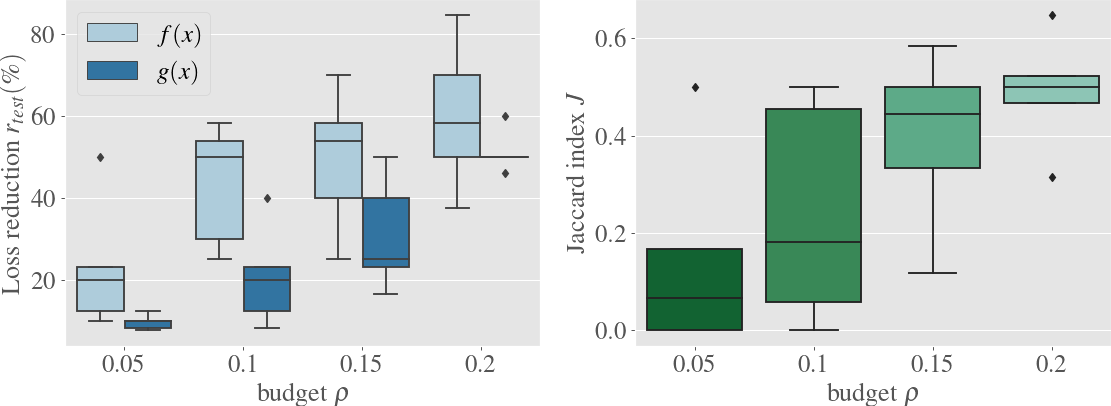

In [34]:
fig, ax = plt.subplots(1,2,figsize=(15, 5.1), constrained_layout=False, dpi=90)
pal = sns.color_palette('Paired')
sns.boxplot(x=df['rho_user'], y=df['%reduction_test'], hue='label', data=df, ax=ax[0], palette=pal)
ax[0].set_xlabel(r'budget $\rho$')
ax[0].set_ylabel(r'Loss reduction $r_{test}(\%)$')
ax[0].legend(loc='upper left')
pal = sns.color_palette('BuGn_r')
sns.boxplot(x=df_jaccard['rho_user'], y=df_jaccard['jaccard'], data=df_jaccard, ax=ax[1], palette=pal)
ax[1].set_xlabel(r'budget $\rho$')
ax[1].set_ylabel(r'Jaccard index $J$');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: The following kwargs were not used by contour: 'label'


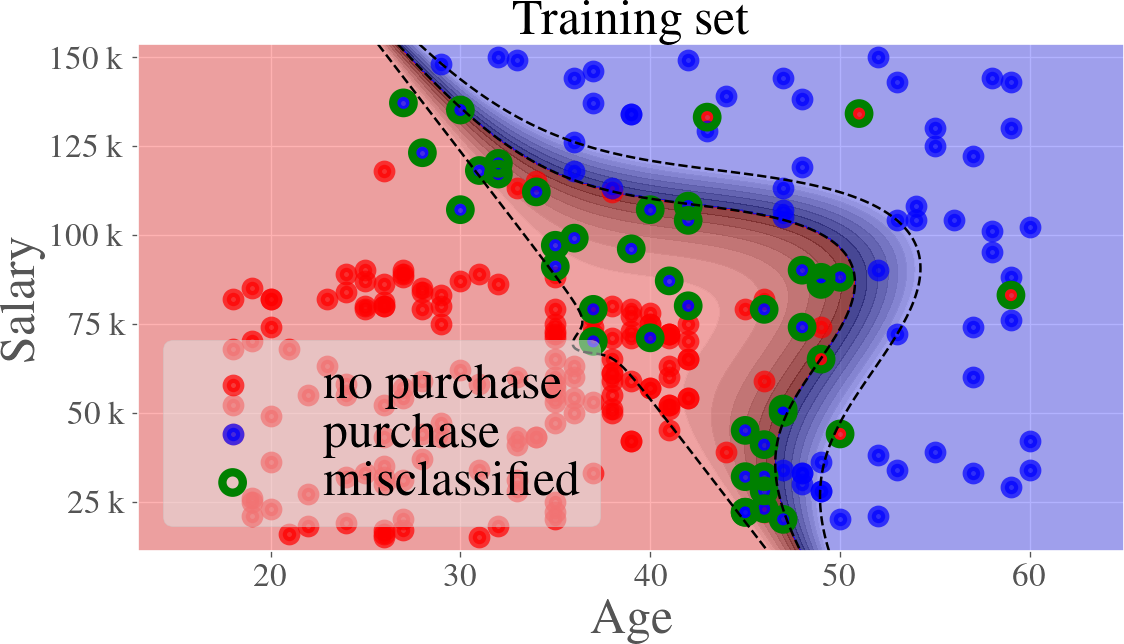

In [35]:
#%%
# PLOT DECISION SURFACE
# ==================
# Plot test instances and decision surface
# ----------------------------------------------
# Visualising the Train set results
fig1 = plt.figure(figsize=(10,6),dpi=120)
ax1 = fig1.add_subplot(111)
X_set, y_set = X_train_surface_plot, y_train_surface_plot
y_set[y_set==0] = -1
if hasattr(classifier, "decision_function"):
    d_set = 1-y_set*classifier.decision_function(X_set)
else:
    pred_x = classifier.predict(X_set)
    pred_x[pred_x==0] = -1
    d_set = y_set*pred_x
xi_set = np.max([[np.zeros(d_set.size)],[d_set]],axis=0).ravel()

aranged_ages = np.arange(start = X_set[:, 0].min()-5, stop = X_set[:, 0].max()+5, step = 0.025)
aranged_salaries = np.arange(start = X_set[:, 1].min()-4000, stop = X_set[:, 1].max()+4000, step = 500)

X1, X2 = np.meshgrid(aranged_ages, aranged_salaries)
Z = classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
if hasattr(classifier, "decision_function"):
    d = classifier.decision_function(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
    ax1.contourf(X1, X2, np.where((np.abs(d)<1),np.abs(d),np.nan), alpha = 0.6, cmap='gist_gray', label='margin region')
    ax1.contour(X1, X2, d, levels=[-1, 0, 1], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set>1,0]
    y = X_set[xi_set>1,1]
else:
    d = classifier.predict_proba(np.array([X1.ravel(), X2.ravel()]).T)[:, 1].reshape(X1.shape)-0.5
    ax1.contourf(X1, X2, np.where((np.abs(d)<0.25),np.abs(d),np.nan), alpha = 0.6, cmap='gist_gray', label='margin region')
    ax1.contour(X1, X2, d, levels=[-0.25, 0.0, 0.25], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set==0,0]
    y = X_set[xi_set==0,1]
dots = ['red','blue']
for i, j in enumerate(np.unique(y_set)):
    ax1.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                color = dots[i], label = '{}'.format('no purchase' if i==0 else 'purchase'),alpha=0.7, s=65, linewidths=5)
# Plot slack variables magnitudes
ax1.scatter(x, y, s=150, facecolors='none', edgecolors='g', label='misclassified', linewidths=5)

ax1.set_xlabel('Age', fontsize=30)
ax1.set_ylabel('Salary', fontsize=30)
ax1.set_title('Training set', fontsize=30)
ax1.legend(loc='lower left', framealpha=0.5, prop={'size': 30}, labelspacing=0.0)
formatter0 = matplotlib.ticker.EngFormatter()
ax1.yaxis.set_major_formatter(formatter0)
X1_min, X1_max = X1.min(), X1.max()
X2_min, X2_max = X2.min(), X2.max()
ax1.set_xlim(X1_min, X1_max)
ax1.set_ylim(X2_min, X2_max)
plt.tight_layout()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'label'


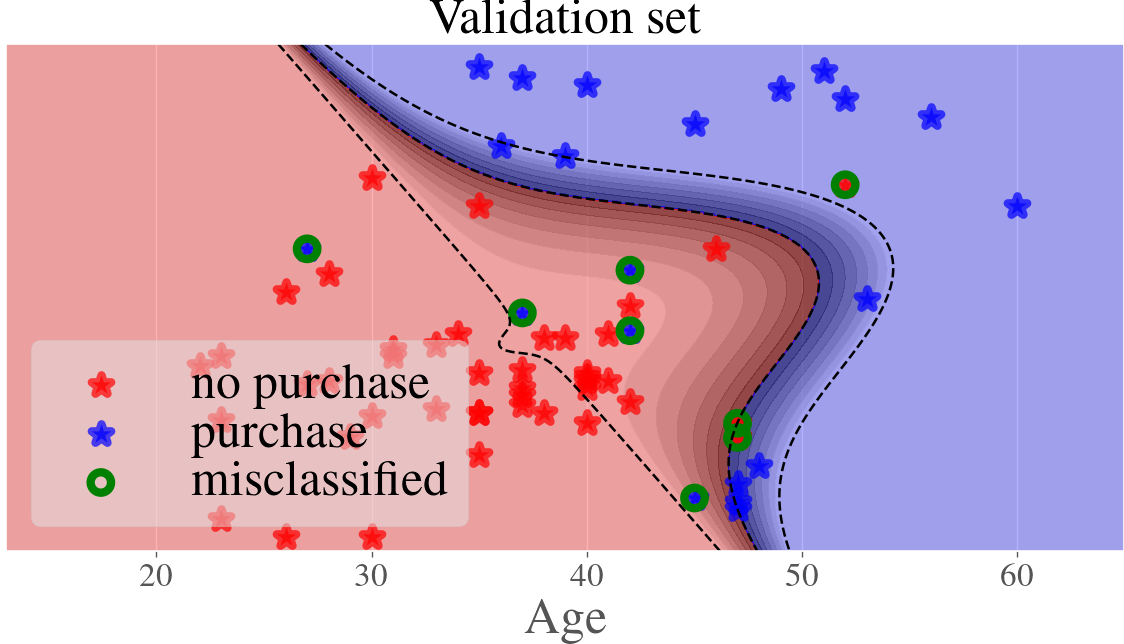

In [36]:
#%%
# PLOT DECISION SURFACE
# ==================
# Plot test instances and decision surface
# ----------------------------------------------
# Visualising the Train set results
fig1 = plt.figure(figsize=(10,6),dpi=120)
ax1 = fig1.add_subplot(111)
X_set, y_set = X_val_surface_plot, y_val_surface_plot
y_set[y_set==0] = -1
if hasattr(classifier, "decision_function"):
    d_set = 1-y_set*classifier.decision_function(X_set)
else:
    pred_x = classifier.predict(X_set)
    pred_x[pred_x==0] = -1
    d_set = y_set*pred_x
xi_set = np.max([[np.zeros(d_set.size)],[d_set]],axis=0).ravel()
if hasattr(classifier, "decision_function"):
    d = classifier.decision_function(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
    ax1.contourf(X1, X2, np.where((np.abs(d)<1),np.abs(d),np.nan), alpha = 0.6, cmap='gist_gray', label='margin region')
    ax1.contour(X1, X2, d, levels=[-1,0,1], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set>1,0]
    y = X_set[xi_set>1,1]
else:
    d = classifier.predict_proba(np.array([X1.ravel(), X2.ravel()]).T)[:, 1].reshape(X1.shape)-0.5
    ax1.contourf(X1, X2, np.where((np.abs(d)<0.25),np.abs(d),np.nan), alpha = 0.6, cmap='gist_gray', label='margin region')
    ax1.contour(X1, X2, d, levels=[-0.25, 0, 0.25], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set==0,0]
    y = X_set[xi_set==0,1]

dots = ['red','blue']
for i, j in enumerate(np.unique(y_set)):
    ax1.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                color = dots[i], label = '{}'.format('no purchase' if i==0 else 'purchase'),alpha=0.7,s=150, marker='*', linewidths=5)
# Plot slack variables magnitudes
ax1.scatter(x, y, s=150, facecolors='none', edgecolors='g', label='misclassified', linewidths=5)
 
ax1.set_xlabel('Age',fontsize=30)
ax1.set_yticks([])
ax1.set_title('Validation set',fontsize=30)
ax1.legend(loc='lower left', framealpha=0.5, prop={'size': 30},labelspacing=0.0)
ax1.set_xlim(X1_min, X1_max)
ax1.set_ylim(X2_min, X2_max)
plt.tight_layout()  

evaluating with cuda...


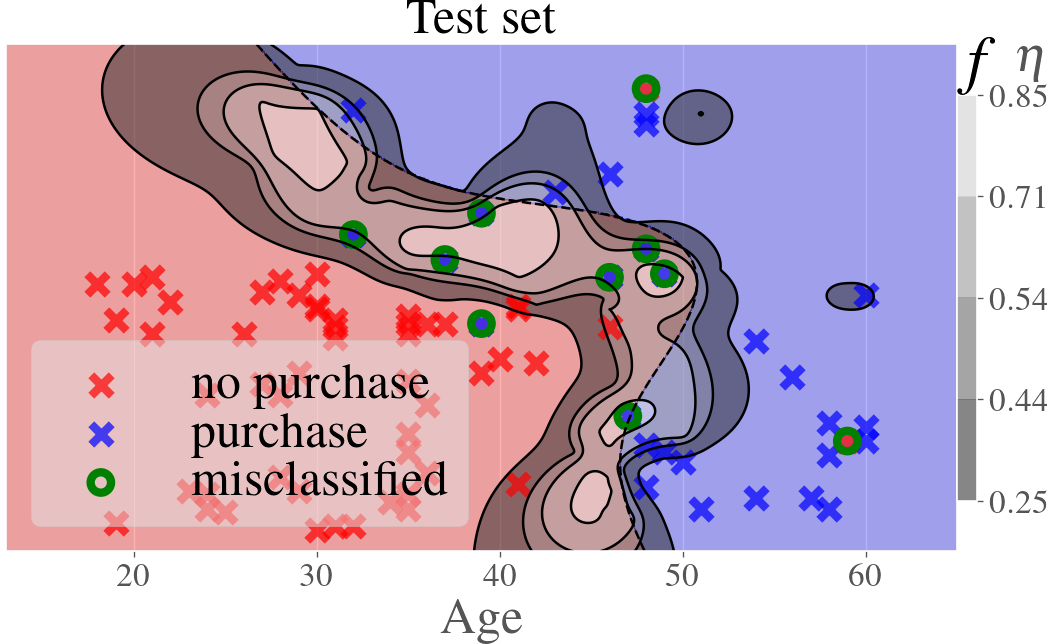

In [39]:
t = np.stack((X1.ravel(), X2.ravel()), axis=1)
t_scaled = scaler_surface_plot.transform(t)
f,v = exp_surface_plot.gpr.predict(t_scaled)
f = f.reshape(X1.shape)
# PLOT DECISION SURFACE
# ==================
# Plot test instances and decision surface
# ----------------------------------------------
# Visualising the Test set results
fig1 = plt.figure(figsize=(10,6),dpi=120)
ax1 = fig1.add_subplot(111)
X_set, y_set = X_test_surface_plot, y_test_surface_plot
y_set[y_set==0] = -1
if hasattr(classifier, "decision_function"):
    d_set = 1-y_set*classifier.decision_function(X_set)
else:
    pred_x = classifier.predict(X_set)
    pred_x[pred_x==0] = -1
    d_set = y_set*pred_x
xi_set = np.max([[np.zeros(d_set.size)],[d_set]],axis=0).ravel()
if hasattr(classifier, "decision_function"):
    d = classifier.decision_function(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
    ax1.contour(X1, X2, d, levels=[0], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set>1,0]
    y = X_set[xi_set>1,1]
else:
    d = classifier.predict_proba(np.array([X1.ravel(), X2.ravel()]).T)[:, 1].reshape(X1.shape)
    ax1.contour(X1, X2, d, levels=[0.5], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set==0,0]
    y = X_set[xi_set==0,1]

f_set = table_surface_plot['eta'].to_numpy()[::-1]
f_set = np.unique(np.around(np.append(f_set, f.max()), decimals=2))
cs = ax1.contourf(X1, X2, f, f_set, origin='upper', cmap='gray', alpha=0.5)
ax1.contour(X1, X2, f, f_set, colors='black')
cbar = fig1.colorbar(cs, pad=0.0, shrink=0.80)
cbar.ax.set_title(r'$f$', fontsize=40, loc='left')
cbar.set_label(r'$\eta$', labelpad=-10, y=1.14, rotation=0, fontsize=30)
dots = ['red','blue']
for i, j in enumerate(np.unique(y_set)):
    ax1.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                color = dots[i], label = '{}'.format('no purchase' if i==0 else 'purchase'), alpha=0.7, s=150,marker='x', linewidth=5)
# Plot slack variables magnitudes
ax1.scatter(x, y, s=150, facecolors='none', edgecolors='g', label='misclassified', linewidths=5)

ax1.set_xlabel('Age',fontsize=30)
ax1.set_yticks([])
ax1.set_title('Test set',fontsize=30)
ax1.legend(loc='lower left', framealpha=0.5, prop={'size': 30}, labelspacing=0.0)
ax1.set_xlim(X1_min, X1_max)
ax1.set_ylim(X2_min, X2_max)
plt.tight_layout()

In [45]:
report_table_concat = pd.concat(report_table)
table_by_row_index = report_table_concat.groupby(report_table_concat.index)
report_table_mean = table_by_row_index.mean()
report_table_std = table_by_row_index.std()
report_table_median = table_by_row_index.median()
report_table_q1 = table_by_row_index.quantile(q=0.25)
report_table_q3 = table_by_row_index.quantile(q=0.75)

report_criteria_concat = pd.concat(report_criteria)
table_by_row_index = report_criteria_concat.groupby(report_criteria_concat.index)
report_criteria_mean = table_by_row_index.mean()
report_criteria_std = table_by_row_index.std()
report_criteria_median = table_by_row_index.median()
report_criteria_q1 = table_by_row_index.quantile(q=0.25)
report_criteria_q3 = table_by_row_index.quantile(q=0.75)

In [ ]:
##%
# Signaling function statistics (median(q1-q3))
output = io.StringIO()
columns = ['%reduction_val','budget','%reduction_test']
df1 = report_table_median[columns]
df2 = report_table_q1[columns]
df3 = report_table_q3[columns]
pval = report_table_mean['p_value']
rho = report_table_mean['rho_user']
assert(df1.shape[0]==df2.shape[0])
numRows = df1.shape[0]
for i in range(numRows):
  row = [r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) if pval[i]<=0.05 and j!=1 else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3)\
       if pval[i]<=0.05 and j==1 else r'{}' for val1,val2,val3,j in zip(df1.iloc[i],df2.iloc[i],df3.iloc[i],range(len(columns)))]
  output.write("{{}} & {{}} & {rho:.2f} & %s & {H0} \\\\\n".format(rho=rho[i], H0=r'$\surd$' if pval[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output.getvalue())

In [ ]:
##%
# Signaling function statistics (mean+/-std)
output = io.StringIO()
columns = ['%reduction_val','budget','%reduction_test']
df1 = report_table_mean[columns]
df2 = report_table_std[columns]
pval = report_table_mean['p_value']
rho = report_table_mean['rho_user']
assert(df1.shape[0]==df2.shape[0])
numRows = df1.shape[0]
for i in range(numRows):
  row = [r'{:.1f}$\pm${:.1f}'.format(val1,val2) if pval[i]<=0.05 and j!=1 else r'{:.2f}$\pm${:.2f}'.format(val1,val2)\
       if pval[i]<=0.05 and j==1 else r'{}' for val1,val2,j in zip(df1.iloc[i],df2.iloc[i],range(len(columns)))]
  output.write("{{}} & {{}} & {rho:.2f} & %s & {H0} \\\\\n".format(rho=rho[i], H0=r'$\surd$' if pval[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output.getvalue())

In [ ]:
##%
# Comparison statistics (median(q1-q3))
output = io.StringIO()
shared = ['%reduction_test']
df1 = report_table_median[shared]
df2 = report_table_q1[shared]
df3 = report_table_q3[shared]
shared.append('jaccard')
df4 = report_criteria_median[shared]
df5 = report_criteria_q1[shared]
df6 = report_criteria_q3[shared]
pval = report_table_mean['p_value']
rho = report_table_mean['rho_user']
assert(df1.shape[0]==df3.shape[0])
numRows = df1.shape[0]
for i in range(numRows):
  row_table = [r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) if pval[i]<=0.05 else r'{}' for val1,val2,val3 in zip(df1.iloc[i],df2.iloc[i],df3.iloc[i])]
  row_criteria = [r'{:.1f}({:.1f}-{:.1f})'.format(val4,val5,val6) if pval[i]<=0.05 and j==0 else r'{:.2f}({:.2f}-{:.2f})'.format(val4,val5,val6)\
                  if pval[i]<=0.05 and j==1 else r'{}' for val4,val5,val6,j in zip(df4.iloc[i],df5.iloc[i],df6.iloc[i],range(len(columns)))]
  # row =  []
  output.write("{{}} & {{}} & {rho:.2f} & %s & %s & {H0} \\\\\n".format(rho=rho[i], \
                H0=r'$\surd$' if pval[i]<=0.05 else r'$\times$')%(" & ".join(row_table), " & ".join(row_criteria)))
print(output.getvalue())

In [ ]:
##%
# Comparison statistics (mean+/-std)
output = io.StringIO()
shared = ['%reduction_test']
df1 = report_table_mean[shared]
df2 = report_table_std[shared]
shared.append('jaccard')
df3 = report_criteria_mean[shared]
df4 = report_criteria_std[shared]
pval = report_table_mean['p_value']
rho = report_table_mean['rho_user']
assert(df1.shape[0]==df3.shape[0])
numRows = df1.shape[0]
for i in range(numRows):
  row_table = [r'{:.1f}$\pm${:.1f}'.format(val1,val2) if pval[i]<=0.05 else r'{}' for val1,val2 in zip(df1.iloc[i],df2.iloc[i])]
  row_criteria = [r'{:.1f}$\pm${:.1f}'.format(val3,val4) if pval[i]<=0.05 and j==0 else r'{:.2f}$\pm${:.2f}'.format(val3,val4)\
                  if pval[i]<=0.05 and j==1 else r'{}' for val3,val4,j in zip(df3.iloc[i],df4.iloc[i],range(len(columns)))]
  # row =  []
  output.write("{{}} & {{}} & {rho:.2f} & %s & %s & {H0} \\\\\n".format(rho=rho[i], \
                H0=r'$\surd$' if pval[i]<=0.05 else r'$\times$')%(" & ".join(row_table), " & ".join(row_criteria)))
print(output.getvalue())

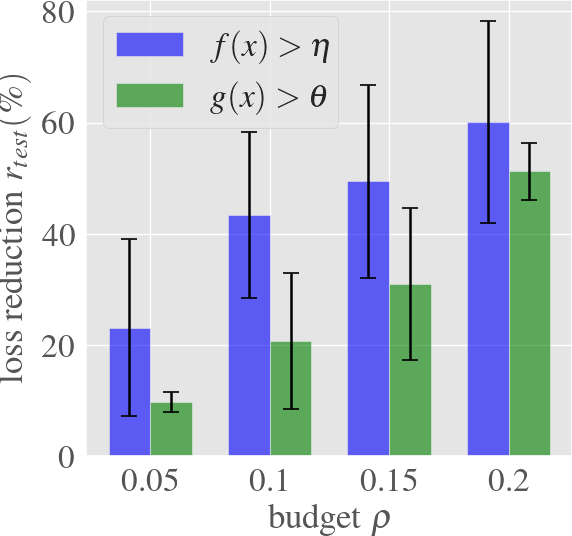

In [116]:
# data to plot
means_table = report_table_mean['%reduction_test'].to_numpy()
means_table[pval>0.05]=0
std_table = report_table_std['%reduction_test'].to_numpy()
std_table[pval>0.05]=0
means_crit = report_criteria_mean['%reduction_test'].to_numpy()
means_crit[pval>0.05]=0
std_crit = report_criteria_std['%reduction_test'].to_numpy()
std_crit[pval>0.05]=0
n_groups = means_table.size

# create plot
fig, ax = plt.subplots(figsize=(5.4, 5.1), constrained_layout=False, dpi=120)
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.6

rects1 = plt.bar(index, means_table, bar_width, yerr=std_table, capsize=5,
alpha=opacity, color='b', label=r'$f(x)>\eta$')

rects2 = plt.bar(index + bar_width, means_crit, bar_width, yerr=std_crit, capsize=5,
alpha=opacity, color='g', label=r'$g(x)>\theta$')

plt.xlabel(r'budget $\rho$')
plt.ylabel(r'loss reduction $r_{test}(\%)$')
# plt.title('Scores by person')
plt.xticks(index + bar_width/2, (['{}'.format(i) for i in report_table_mean['rho_user'].to_numpy()]))
plt.legend()

plt.tight_layout()
plt.show()